# Distracted Driver Recognition
The data set for this project is split into two parts: `labels`, which includes all of the classes for our images and `image_data`, which has a 2-D representation of our images. The possible classes an image can take are:
* Attentive
* DrinkingCoffee
* UsingMirror
* UsingRadio



In [ ]:
#change to the directory with the pretrained .keras files and a zip of the dataset
mainDirectory = "/content/drive/MyDrive/Inspirit1:1/"

In [ ]:
import numpy as np
import pandas as pd
!pip install tensorflow

In [ ]:
if (mainDirectory.find('/content/drive') >= 0):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r /content/sample_data

In [ ]:
import os
datasetDirectory = "KaggleDistractedDriving/"
if (not os.path.isdir(datasetDirectory)):
    !unzip -q {mainDirectory + "KaggleDistractedDriving.zip"} -d KaggleDistractedDriving
else:
    print("Dataset directory already exists")

In [ ]:
my_image_size = (160,120)

(120, 160, 3)


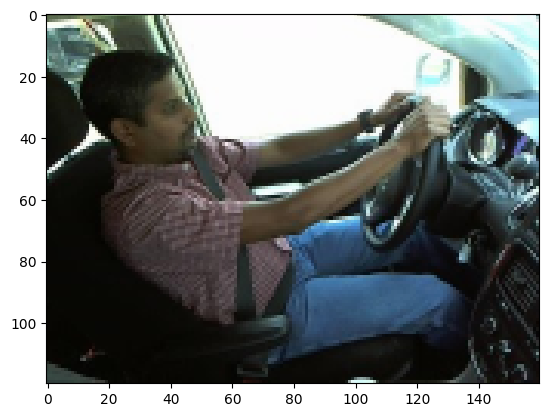

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

#testing cv2's capability of reading images and resizing them
img_34 = cv2.imread(datasetDirectory + 'imgs/train/c0/img_34.jpg')
img_34_normalized = cv2.cvtColor(img_34, cv2.COLOR_BGR2RGB) / 256.0
img_34_resized = cv2.resize(img_34_normalized, dsize=my_image_size)
plt.imshow(img_34_resized)
print(img_34_resized.shape)

You may use Matplotlib's `imshow` function to display the images in your dataset:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import utils
import tensorflow as tf
import time
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2242127203232561378
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 613637507842385827
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

import random
import gc

gc.collect()

def add_noise(img: tf.Tensor, doClipping = True):
    '''Add random noise to an image'''
    VARIABILITY = 30
    deviation = VARIABILITY * (random.random()*0.4 + 0.6)
    noise = tf.random.normal(img.shape, 0, deviation, dtype = img.dtype)
    #return noise
    img += noise
    #return img
    if (doClipping):
        return tf.clip_by_value(img, 0, 255)
    else:
        return img

interpolation = "nearest"
move_augment = keras.Sequential([
    layers.RandomRotation(15/360, interpolation = interpolation),
    layers.RandomTranslation(0.1, 0.1, interpolation = interpolation),
    layers.RandomZoom(0.1, interpolation = interpolation)
])

train_generator, validation_generator = keras.preprocessing.image_dataset_from_directory(
    directory = (datasetDirectory + "imgs/train"),
    batch_size = None,
    shuffle = True,
    seed = 10,
    image_size = (my_image_size[1], my_image_size[0]),
    validation_split = 0.2,
    subset = "both",
    label_mode = "categorical"
)

train_generator_fast = train_generator.batch(512, drop_remainder=True)
train_generator_fast = train_generator_fast.map(lambda x, y: (add_noise(move_augment(x, training=True)), y),
                num_parallel_calls=8).repeat(4)
train_generator_fast = train_generator_fast.cache().prefetch(buffer_size=4)

train_generator_no_augment = train_generator.batch(512, drop_remainder=True).cache().prefetch(buffer_size=4)

train_generator = train_generator.batch(512, drop_remainder=True).cache()
validation_generator = validation_generator.batch(512, drop_remainder=True).cache()

train_generator = train_generator.map(lambda x, y: (add_noise(move_augment(x, training=True)), y),
                num_parallel_calls=8)

train_generator = train_generator.prefetch(buffer_size=4)
validation_generator = validation_generator.prefetch(buffer_size=AUTOTUNE)

gc.collect()

Found 17462 files belonging to 10 classes.
Using 13970 files for training.
Using 3492 files for validation.


0

In [ ]:
print(len(train_generator))

27


In [ ]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
gc.collect()

(512, 120, 160, 3)
(512, 10)


0

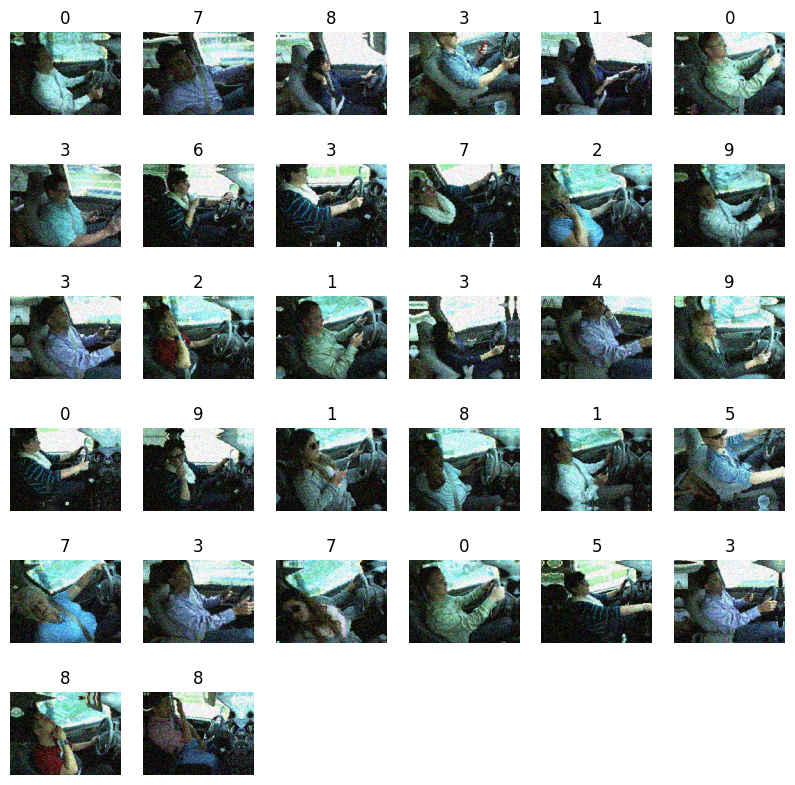

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("int16"))
    plt.title(int(tf.math.argmax(labels[i])))
    plt.axis("off")

In [ ]:
'''conv_model = keras.Sequential(
    [
        layers.Input((64,64,3)),
        layers.Conv2D(5, 5, activation="relu", data_format = "channels_last"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format = "channels_last"),
        layers.Conv2D(10, 5, activation="relu", data_format = "channels_last"),
        layers.MaxPooling2D(pool_size=(2, 2), padding="valid", data_format = "channels_last"),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dense(64),
        layers.Dense(10)
    ]
)'''
'''conv_model = keras.Sequential(
    [
        layers.Input((64,64,3)),
        layers.Flatten(),
        layers.Dense(10)
    ]
)'''
conv_model=keras.Sequential()

conv_model.add(layers.Input((my_image_size[1],my_image_size[0],3)))
conv_model.add(layers.Rescaling(1.0/255))

conv_model.add(layers.Conv2D(32, (5,5),activation='leaky_relu'))
#conv_model.add(layers.Dropout(0.25))
conv_model.add(layers.MaxPooling2D(3,3))

#conv_model.add(layers.BatchNormalization())
conv_model.add(layers.Conv2D(12, (5,5), activation="leaky_relu"))
conv_model.add(layers.MaxPooling2D(3,3))
#conv_model.add(layers.Conv2D(128, (3,3), activation="relu"))
#conv_model.add(layers.MaxPooling2D(2,2))
#conv_model.add(layers.Conv2D(128, (3,3), activation="relu"))
#conv_model.add(layers.MaxPooling2D(2,2))
#conv_model.add(layers.BatchNormalization())
conv_model.add(layers.Flatten())
#conv_model.add(layers.Dropout(0.2))
conv_model.add(layers.Dense(64,activation='leaky_relu'))
conv_model.add(layers.Dense(10, activation='softmax'))
conv_model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer='adam', metrics = ['categorical_accuracy'])

conv_model.summary()

#on 128x128 images:
#full model is usable after epoch 5, trains in stated 84 seconds (1 min 24 sec)
#not including the intermediate 64 filter and 128 filter layers (and the corresponding max pools)
#   gives a comparable train time at 82 seconds, performance not affected
#not including the 2 128 filter layers and having more aggressive max pooling (4x4)
#   gets 72 seconds (1 min 12 sec) with about same performance
#same as above but with the first dense layer being 64 rather than 512 neurons
#   gets 69 seconds(1 min 9 sec) but decreases performance noticably

#I suspect that grabbing the images from disk is the main limiting factor here
#but with no real alternative this is good enough

#a (32, 3, 3) conv layer, (3, 3) max pooling, (64, 3, 3) conv layer, (3, 3) max pooling, 512 dense, and 10 dense works fairly well with (80,60) sized images
#same model is reasonable with (60, 48) images. Not great though.
#reducing both max poolings to (2, 2) makes it perform much better, with no double-digit errors

#going back up to (160, 120)
#(32,5,5) conv layer, (3,3) max pooling, (64,5,5) conv layer, (3,3) max pooling, 512 dense, and 10 dense works well
#two points of interest: there are only a few activations in a ton of lows. Some neurons appear to be basically unused.
#my theory: the larger kernels pick up more complex details, removing the need for some neurons as more information is packed into the other neurons
#trying again with two (32,5,5) conv layers appears to remove all the wasted neurons with no loss of accuracy
#interestingly, it seems that there might be room to cut more neurons

#with extra noise and data amplification:
#seems like the model (32,5,5),(3,3),(32,5,5),(3,3),512,10 is losing accuracy
#I'll try increase

#testing different data modification permutations:
#using a (64, 5, 5) conv, (3,3) pooling, (32,5,5) conv, (3,3) pooling, (512) dense, and (10 dense)

#no noise or transformations in general predictably gets extremely high training accuracy in 3 epochs  and high validation accuracy
#if it is of interest, 2 minutes to generate the dataset
#however, I am showing the same data to the model 4 times per epoch so...
#interestingly, 2 has the highest variation while 4 5 and 6 have the least. Train accuracy is 0.9975 and validation accuracy is 0.9887 (first run)
# 0 has least variation while 7 and 1 have highest variation, though it seems like it's random (second run)
#third run, same accuracy (0.9987 train, 0.9930 validation). 0 is very low, 3 is very high for some reason

#rotation only (20 degrees)
#takes 7 minutes to generate dataset
#predictably, the aggregation inside one category is blobby
#interestingly, performance doesn't suffer too much (even with same 3 epochs)
#first run: 0.9726 train accuracy, 0.9668 validation accuracy (still pretty good)
#more dead neurons than before. Seems like 8 and 1 have high variation while 9 is bad
#second run: 0.9786 train accuracy, 0.9660 validation accuracy. Most mistakes come from mistakenly classifying stuff as 4
#same number of dead neurons (of course). 1 and 7 have high variation and 0 is the only low variation output.
#third run: 0.9792 train accuracy, 0.9716 validation accuracy. Most mistakes are related to 0.
#1 has highest variation, 8 and 2 are low while 0 is relatively low.

#width shift and zoom (all 0.1)
#takes 7 minutes to generate dataset
#aggregation inside one category looks about as blobby as rotation
#seems to prune down to the two neurons seen with all modifiers active
#first run: 0.8212 train accuracy, 0.8476 validation accuracy (so worse than rotation) (3 epochs again)
#struggles with 0 and 8. 7 and 5 have high variation, while 8 has low variation
#second run: 0.9103 train accuracy, 0.8990 validation accuracy
#has inaccuracy, but less than before. 11 active neurons in the second convolutional layer.
#5 and 1 have high variation, 0 has low variation
#third run: 0.9223 train accuracy, 0.9197 validation accuracy
#no error cases with over 100, though confusing 0 with 9 had 95. Has 9 active neurons in the second conv layer.
#1 has high variation, 0 has low variation. Others vary quite a bit.

#noise only (VARIABILITY = 30)
#takes 4 min to generate dataset
#aggregation has sharp edges
#first run: 0.9982 train accuracy, 0.9900 validation accuracy. (comparable to no modifiers) (3 epochs)
#11 active neurons in second layer
#6, 9, and 7 have high variation, 0, 2, and 1 have low variation.
#second run: 0.9842 train accuracy, 0.9765 validation accuracy
#back to 2 active neurons.
#5 has high variation, 8 and 0 have low variation
#third run: 0.9961 train accuracy, 0.9861 validation accuracy.
#4 neurons in second layer
#3, 6, and 8 have high variation, 0 has low variation.

#rotation, width shift, and zoom
#took 1m (? exceedingly fast) to generate dataset
#aggregation is blobby, again
#first run: 0.8870 train accuracy, 0.8832 validation accuracy
#12 neurons in second layer
#1 has high variation, 0 and 9 have low variation
#second run: 0.8783 train accuracy, 0.8575 validation accuracy
#7 neurons in second layer
#5 and 6 have high variation, 9 and 8 have low variation
#third run: 0.7755 train accuracy, 0.7969 validation accuracy
#5 neurons in second layer
#5 has high variation, while 0, 9, and 8 have low variation

#rotation and noise
#took 9 min to generate
#first run: 0.9496 train accuracy, 0.9534 validation accuracy
#4 neurons in second layer
#7 has high variation, 0 and 3 have low variation
#second run: 0.9625 train accuracy, 0.9565 validation accuracy
#6 neurons in second layer
#1 and 7 have high variation, 0, 4, and 2 have low variation
#third run: 0.9625 train accuracy, 0.9530 validation accuracy
#4 neurons in second layer
#7 and 6 have high variation, 4 and 3 have low variation

#width shift and noise
#took 9 min to generate
#first run: 0.7601 train accuracy, 0.7615 validation accuracy
#1 neuron in second layer
#5 and 1 have high variation, 0, 9, 4, and 8 have low variation
#second run: 0.8271 train accuracy, 0.8316 validation accuracy. Does struggle with overpredicting 0
#2 neurons in second layer
#5 has high variation, 9, 8, and 4 have low variation
#third run: 0.8345 train accuracy, 0.8257 validation accuracy. Overpredicts 8 now
#3 neurons in second layer
#1 has high variation, 2 and 9 have low variation

#after data pipeline revamp:
#my model:
#120 epochs, approx 26 min train time on a T4 GPU
#changed first dense layer, 256 -> 128 -> 64
#changed activation, relu -> leaky_relu
#changed second conv layer, 8 -> 12
#120 epochs, 26 min 37 sec train time on a T4 GPU
#after 120 epochs of augmented training, used 20 epochs of non-augmented training to refine accuracy
#this step increased validation accuracy to 99.5%, while still leaving an augmented accuracy of ~94.5%
#(from 98.8% validation and ~96.9% augmented)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 116, 156, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 38, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 34, 48, 12)          │           9,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 16, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2112)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         135,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147,926 (577.84 KB)

 Trainable params: 147,926 (577.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "conv_model_pretrained64lrelu12conv2.keras"} /content/conv_model_pretrained64lrelu12conv2.keras
    conv_model = keras.models.load_model("conv_model_pretrained64lrelu12conv2.keras", compile = False)
    conv_model.compile(loss=keras.losses.CategoricalFocalCrossentropy(), optimizer='adam', metrics = ['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    conv_model.fit(x=train_generator.repeat(), steps_per_epoch = len(train_generator), epochs=120, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
conv_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - categorical_accuracy: 0.9963 - loss: 0.0017


[0.002143316203728318, 0.9951171875]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(conv_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[331,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 306,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0, 302,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 309,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0, 313,   0,   0,   0,   1,   0],
       [  0,   0,   1,   0,   0, 349,   0,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0, 336,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 245,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1, 280,   2],
       [  1,   0,   0,   0,   0,   0,   0,   0,   4, 286]], dtype=int32)

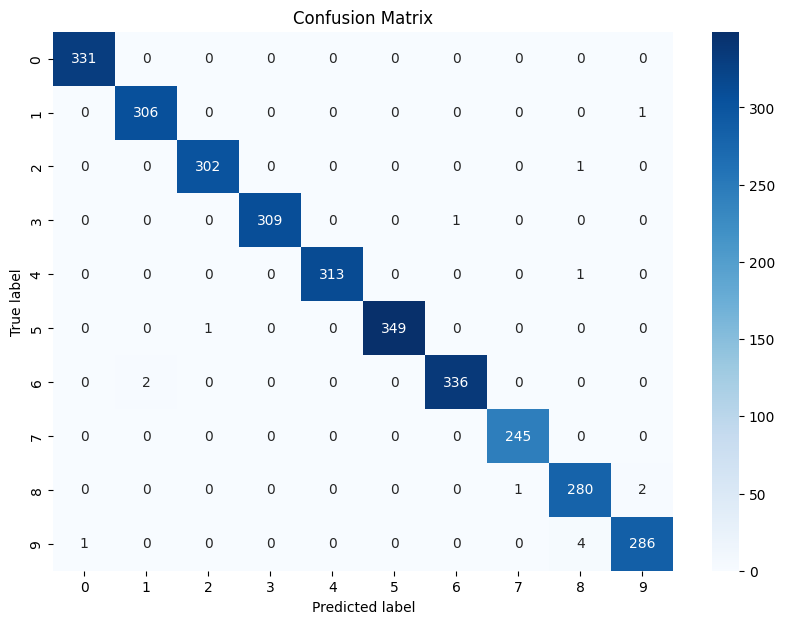

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#print(conv_model.score(X_test,y_test))
# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    conv_model.save("conv_model_pretrained64lrelu12conv2.keras")
    print(os.path.getsize('/content/conv_model_pretrained64lrelu12conv2.keras'))
    !cp conv_model_pretrained64lrelu12conv2.keras {mainDirectory + "conv_model_pretrained64lrelu12conv2.keras"}

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
#source: https://colab.research.google.com/drive/1ZFntSpTYZfVW8k4VfvVIi_IZ5xdjF_qS#scrollTo=XLJNVGwHUDy1

bnmomemtum=0.9
def fire(x, squeeze, expand):
    y  = layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = layers.Input((my_image_size[1], my_image_size[0],3))
x = layers.Rescaling(1.0/255)(x)

y = layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dense(10, activation='softmax')(y)

squeeze_model = keras.Model(x, y)

squeeze_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

squeeze_model.summary()

#note: model doesn't generalize well
#forced to use mixed precision because of out of memory issues
#used 120 epochs for this run
#at 15 epochs, the model has 98.7% accuracy on training set but only 86.6% accuracy on validation set
#achieves 90% accuracy at epoch 23, gets an outlier of 96.3% at epoch 55 (among 91% accuracy epochs)
#at epoch 114, the model gets 100% accuracy on training set and 97.0% accuracy on validation set
#took 50 min and 57 sec to train, final accuracy 94.2% (due to randomness)

#without data augmentation:
#used 20 epochs
#at 10 epochs, achieves 100.0% accuracy on training set and 99.2% accuracy on validation set
#took 8 min and 25 sec to train, final accuracy 99.4%
#for curiosity's sake, I checked the accuracy on the augmented training set, it got 11.1% accuracy

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_78CLONE      │ (None, 120, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 120, 160, 32)   │            896 │ keras_tensor_78CLONE[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 120, 160, 32)   │            128 │ conv2d_2[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 120, 160, 24)   │            792 │ batch_normalization[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 120, 160, 24)   │             96 │ conv2d_3[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 120, 160, 24)   │            600 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 120, 160, 24)   │          5,208 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 120, 160, 24)   │             96 │ conv2d_4[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 120, 160, 24)   │             96 │ conv2d_5[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 120, 160, 48)   │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 60, 80, 48)     │              0 │ concatenate[1][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 60, 80, 48)     │          2,352 │ max_pooling2d_2[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 80, 48)     │            192 │ conv2d_6[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 60, 80, 48)     │          2,352 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 60, 80, 48)     │         20,784 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 120,858 (472.10 KB)

 Trainable params: 119,546 (466.98 KB)

 Non-trainable params: 1,312 (5.12 KB)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "squeeze_model_pretrained2.keras"} squeeze_model_pretrained2.keras
    squeeze_model = keras.models.load_model("squeeze_model_pretrained2.keras", compile = False)
    squeeze_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    squeeze_model.fit(x=train_generator_no_augment.repeat(), steps_per_epoch = len(train_generator_no_augment), epochs=20, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
squeeze_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - categorical_accuracy: 0.9935 - loss: 0.0337


[0.03272595256567001, 0.994140625]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(squeeze_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[329,   0,   0,   1,   0,   0,   0,   0,   0,   1],
       [  0, 307,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 303,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 306,   4,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 313,   0,   1,   0,   0,   0],
       [  1,   0,   0,   0,   0, 348,   1,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0, 336,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0, 243,   1,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 281,   1],
       [  1,   0,   0,   0,   1,   1,   0,   0,   0, 288]], dtype=int32)

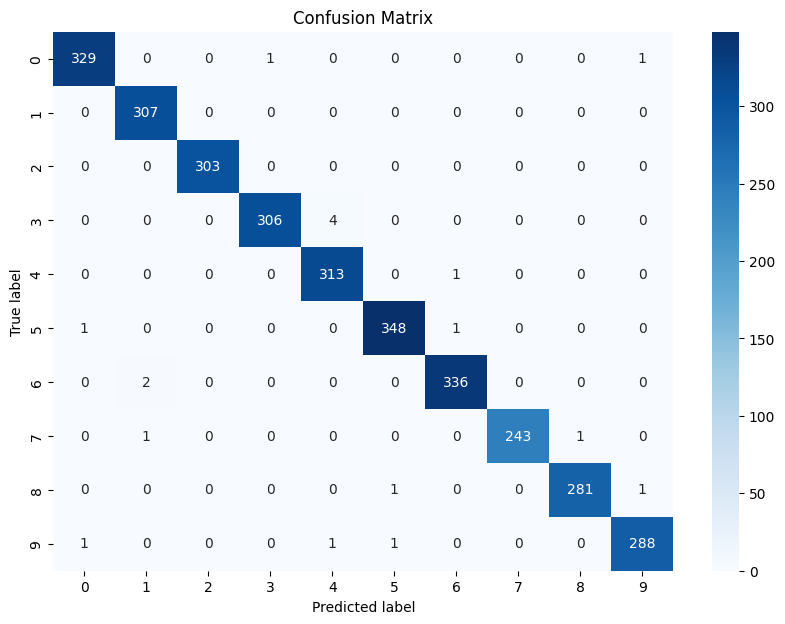

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    squeeze_model.save("squeeze_model_pretrained2.keras")
    print(os.path.getsize('squeeze_model_pretrained2.keras'))
    !cp squeeze_model_pretrained2.keras {mainDirectory + "squeeze_model_pretrained2.keras"}

In [ ]:
alex_model = keras.Sequential()

# Input layer and rescaling
alex_model.add(layers.Input((my_image_size[1], my_image_size[0],3)))
alex_model.add(layers.Rescaling(1.0/255))

# Layer 1: Convolutional layer with 64 filters of size 11x11x3
alex_model.add(layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(224,224,3)))

# Layer 2: Max pooling layer with pool size of 3x3
alex_model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
alex_model.add(layers.Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
alex_model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
alex_model.add(layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
alex_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
alex_model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 6: Fully connected layer with 4096 neurons
alex_model.add(layers.Flatten())
alex_model.add(layers.Dense(4096, activation='relu'))

# Layer 7: Fully connected layer with 4096 neurons
alex_model.add(layers.Dense(4096, activation='relu'))

# Output layer
alex_model.add(layers.Dense(10, activation='softmax'))

alex_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

alex_model.summary()

#trained for 120 epochs
#notably, alexnet attained 99% accuracy at epoch 60 and ended up with 99.1% accuracy at epoch 120
#trained for 29 min and 41 sec

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 38, 64)          │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 13, 18, 192)         │         307,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 8, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 6, 8, 384)           │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 6, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,997,450 (95.36 MB)

 Trainable params: 24,997,450 (95.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "alex_model_pretrained.keras"} alex_model_pretrained.keras
    alex_model = keras.models.load_model("alex_model_pretrained.keras", compile = False)
    alex_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    alex_model.fit(x=train_generator.repeat(), steps_per_epoch = len(train_generator), epochs=120, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
alex_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - categorical_accuracy: 0.9918 - loss: 0.0354


[0.04259425401687622, 0.9912109375]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(alex_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[327,   0,   0,   0,   3,   0,   0,   0,   0,   1],
       [  0, 305,   0,   0,   0,   0,   1,   0,   0,   1],
       [  0,   0, 303,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   1, 307,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 313,   0,   1,   0,   0,   0],
       [  2,   0,   0,   0,   0, 347,   0,   0,   0,   1],
       [  0,   0,   3,   0,   0,   0, 335,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0, 244,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 282,   1],
       [  1,   1,   0,   0,   0,   0,   0,   0,   7, 282]], dtype=int32)

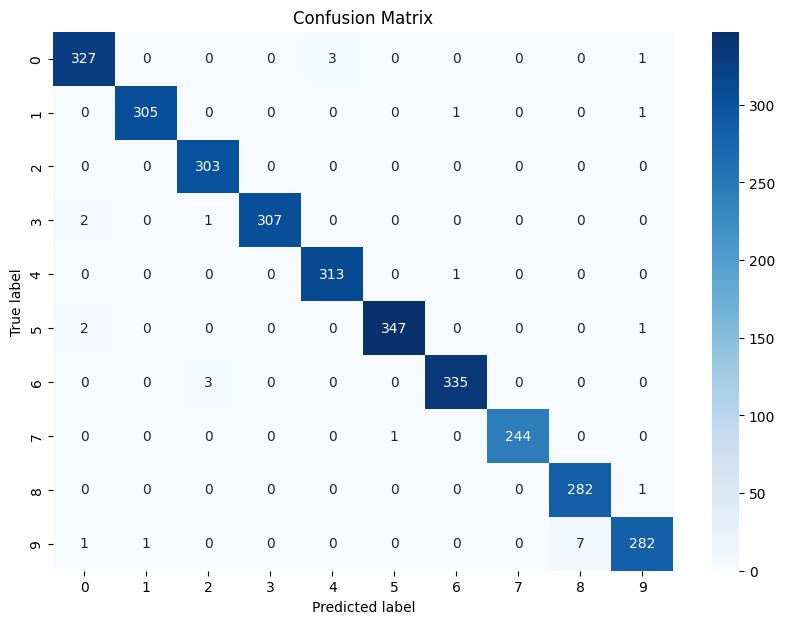

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    alex_model.save("alex_model_pretrained.keras")
    print(os.path.getsize('alex_model_pretrained.keras'))
    !cp alex_model_pretrained.keras {mainDirectory + "alex_model_pretrained.keras"}

In [ ]:
mobile_model_inner = keras.applications.MobileNetV2(
    input_shape=(my_image_size[1], my_image_size[0],3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None
)
mobile_model_inner.trainable = False

inputs = layers.Input(shape=(my_image_size[1], my_image_size[0],3))
inputs_r = layers.Rescaling(1.0/255)(inputs)

x = mobile_model_inner(inputs_r, training=False)

outputs = layers.Flatten()(x)
outputs = layers.Dense(32, activation = "leaky_relu")(outputs)
outputs = layers.Dense(10, activation = "softmax")(outputs)

mobile_model = keras.Model(inputs, outputs)

mobile_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

mobile_model.summary()

#had to use two dense layers, otherwise the model doesn't learn well
#had to use no augmentation, otherwise the model overfits on augmented data and doesn't gain validation accuracy
#used 10 epochs, took 49 seconds to train

<ipython-input-37-9111026e08d1>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_model_inner = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 4, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │         819,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,077,546 (11.74 MB)

 Trainable params: 819,562 (3.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "mobile_model_pretrained.keras"} mobile_model_pretrained.keras
    mobile_model = keras.models.load_model("mobile_model_pretrained.keras", compile = False)
    mobile_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    mobile_model.fit(x=train_generator_no_augment.repeat(), steps_per_epoch = len(train_generator_no_augment), epochs=10, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
mobile_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - categorical_accuracy: 0.9949 - loss: 0.0335


[0.03407454863190651, 0.994140625]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(mobile_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[330,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0, 307,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 302,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 309,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   1, 311,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   1, 349,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 337,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 245,   0,   0],
       [  0,   0,   1,   0,   1,   0,   0,   1, 276,   4],
       [  0,   1,   0,   0,   0,   1,   0,   0,   1, 288]], dtype=int32)

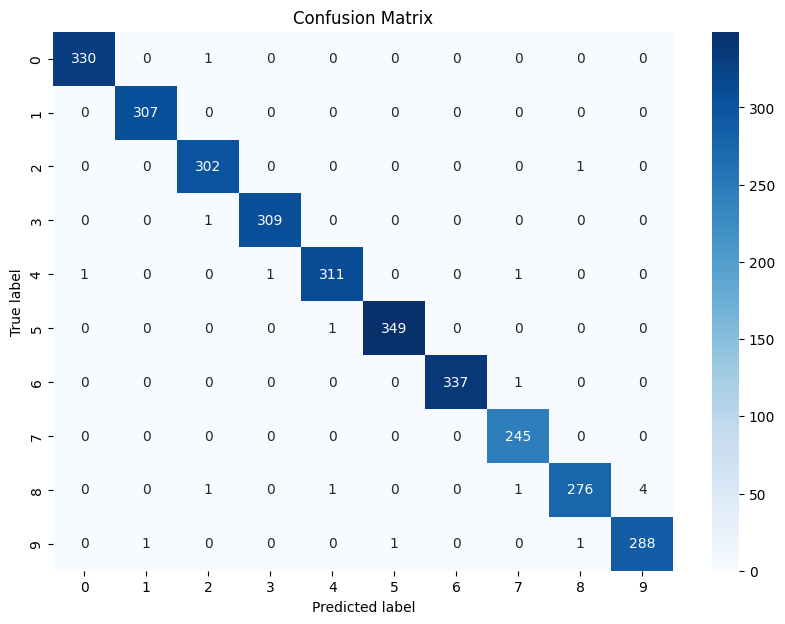

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    mobile_model.save("mobile_model_pretrained.keras")
    print(os.path.getsize('/content/mobile_model_pretrained.keras'))
    !cp mobile_model_pretrained.keras {mainDirectory + "mobile_model_pretrained.keras"}

In [ ]:
vgg_model_inner = keras.applications.VGG16(
    input_shape=(my_image_size[1], my_image_size[0],3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None
)
vgg_model_inner.trainable = False

inputs = layers.Input(shape=(my_image_size[1], my_image_size[0],3))
inputs_r = layers.Rescaling(1.0/255)(inputs)

x = vgg_model_inner(inputs_r, training=False)

outputs = layers.Flatten()(x)
outputs = layers.Dense(32, activation = "leaky_relu")(outputs)
outputs = layers.Dense(10, activation = "softmax")(outputs)

vgg_model = keras.Model(inputs, outputs)

vgg_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

vgg_model.summary()

#had to use no augmentation, otherwise the model doesn't gain validation accuracy
#used 10 epochs to train
#took 1 min and 54 seconds to train


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │         245,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,960,810 (57.07 MB)

 Trainable params: 246,122 (961.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "vgg_model_pretrained.keras"} vgg_model_pretrained.keras
    vgg_model = keras.models.load_model("vgg_model_pretrained.keras", compile = False)
    vgg_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    vgg_model.fit(x=train_generator_no_augment.repeat(), steps_per_epoch = len(train_generator_no_augment), epochs=10, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
vgg_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 111s 331ms/step - categorical_accuracy: 0.9940 - loss: 0.0500


[0.050914183259010315, 0.9938151240348816]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(vgg_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[326,   0,   2,   0,   2,   0,   0,   0,   1,   0],
       [  0, 306,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 302,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 310,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 314,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0, 348,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 338,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 245,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1, 281,   1],
       [  3,   2,   0,   1,   0,   0,   1,   0,   1, 283]], dtype=int32)

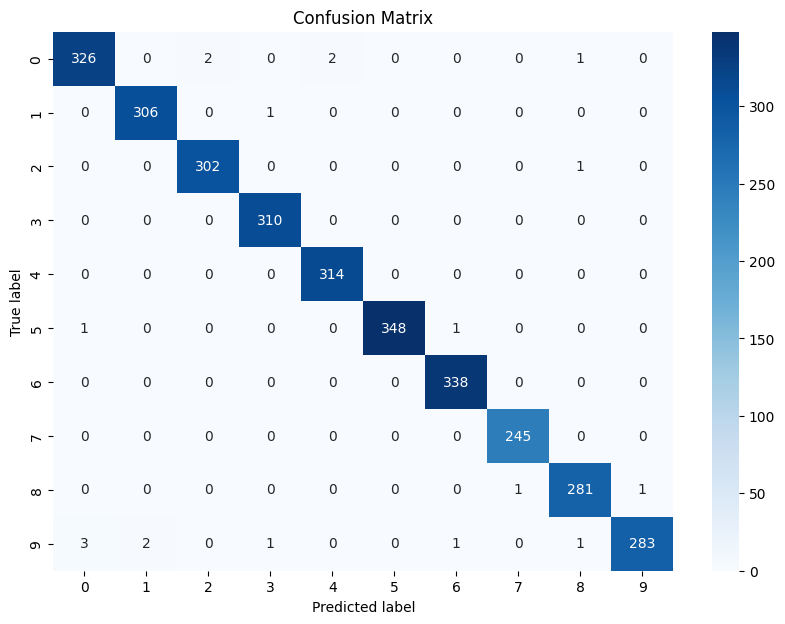

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    vgg_model.save("vgg_model_pretrained.keras")
    print(os.path.getsize('/content/vgg_model_pretrained.keras'))
    !cp vgg_model_pretrained.keras {mainDirectory + "vgg_model_pretrained.keras"}

In [ ]:
inception_model_inner = keras.applications.InceptionV3(
    input_shape=(my_image_size[1], my_image_size[0],3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None
)
inception_model_inner.trainable = False

inputs = layers.Input(shape=(my_image_size[1], my_image_size[0],3))
inputs_r = layers.Rescaling(1.0/255)(inputs)

x = inception_model_inner(inputs_r, training=False)

outputs = layers.Flatten()(x)
outputs = layers.Dense(32, activation = "leaky_relu")(outputs)
outputs = layers.Dense(10, activation = "softmax")(outputs)

inception_model = keras.Model(inputs, outputs)

inception_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

inception_model.summary()

#training with augmented data fails to converge
#with non-augmented data and 20 epochs, it took 1 min 44 sec to train

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │         393,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,196,362 (84.67 MB)

 Trainable params: 393,578 (1.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
unzipFiles = True
if (unzipFiles):
    !cp {mainDirectory + "inception_model_pretrained.keras"} inception_model_pretrained.keras
    inception_model = keras.models.load_model("inception_model_pretrained.keras", compile = False)
    inception_model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['categorical_accuracy'])

In [ ]:
if (not unzipFiles):
    print("Training.")
    start_time = time.time()
    inception_model.fit(x=train_generator_no_augment.repeat(), steps_per_epoch = len(train_generator_no_augment), epochs=20, workers=2, use_multiprocessing=True, validation_data = validation_generator, validation_steps = len(validation_generator))
    end_time = time.time()
    print("Took "+str(round(end_time-start_time,2))+" seconds to train.")

In [ ]:
inception_model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - categorical_accuracy: 0.9696 - loss: 0.1079


[0.09940066188573837, 0.9713541865348816]

In [ ]:
predictions = np.array([])
validation_labels = np.array([])
for x, y in validation_generator:
    predictions = np.concatenate([predictions, np.argmax(vgg_model.predict(x),axis=-1)])
    validation_labels = np.concatenate([validation_labels, np.argmax(np.array(y), axis=-1)])

np.array(tf.math.confusion_matrix(labels=validation_labels, predictions=predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[326,   0,   2,   0,   2,   0,   0,   0,   1,   0],
       [  0, 306,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 302,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0, 310,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 314,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0, 348,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 338,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 245,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1, 281,   1],
       [  3,   2,   0,   1,   0,   0,   1,   0,   1, 283]], dtype=int32)

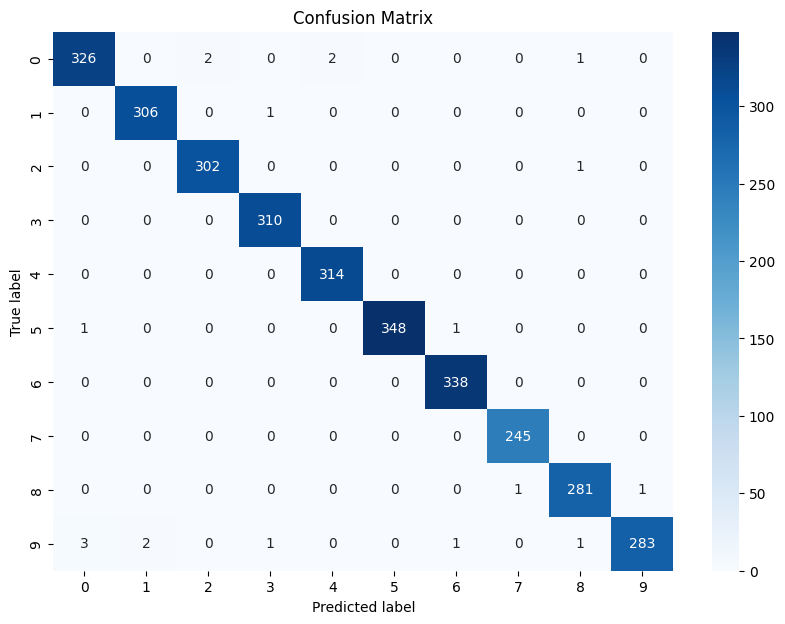

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
distinct_labels = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(validation_labels,  predictions, labels=distinct_labels)

# Plotting the confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=distinct_labels, yticklabels=distinct_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
make_zip = False
if (make_zip):
    inception_model.save("inception_model_pretrained.keras")
    print(os.path.getsize('/content/inception_model_pretrained.keras'))
    !cp inception_model_pretrained.keras {mainDirectory + "inception_model_pretrained.keras"}

In [ ]:
def get_flops(model):
    #if isinstance(model,(keras.engine.functional.Functional,keras.engine.training.Model)):
        run_meta=tf.compat.v1.RunMetadata()
        opts=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        from tensorflow.python.framework.convert_to_constants import (convert_variables_to_constants_v2_as_graph)
        inputs=[tf.TensorSpec([1]+list(inp.shape[1:]),inp.dtype) for inp in model.inputs]
        real_model=tf.function(model).get_concrete_function(inputs)
        frozen_func,_=convert_variables_to_constants_v2_as_graph(real_model)
        flops=tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta,cmd="scope",options=opts)
        return flops.total_float_ops
def get_size(model):
    return np.sum([np.prod(v.shape) for v in model.variables])

In [ ]:
flop_list = []
flop_list.append(get_flops(conv_model))
flop_list.append(get_flops(squeeze_model))
flop_list.append(get_flops(alex_model))
flop_list.append(get_flops(mobile_model))
flop_list.append(get_flops(vgg_model))
flop_list.append(get_flops(inception_model))

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


In [ ]:
print(f"{'Custom Conv Model Flops:':<24} {flop_list[0]:>11}")
print(f"{'SqueezeNet Flops:':<24} {flop_list[1]:>11}")
print(f"{'AlexNet Flops:':<24} {flop_list[2]:>11}")
print(f"{'MobileNetV2 Flops:':<24} {flop_list[3]:>11}")
print(f"{'VGG-16 Flops:':<24} {flop_list[4]:>11}")
print(f"{'Inception V3 Flops:':<24} {flop_list[5]:>11}")

Custom Conv Model Flops:   119768892
SqueezeNet Flops:          669315276
AlexNet Flops:             388560956
MobileNetV2 Flops:         245601308
VGG-16 Flops:            11682199772
Inception V3 Flops:       1730748124


In [ ]:
parameters_list = []
parameters_list.append(get_size(conv_model))
parameters_list.append(get_size(squeeze_model))
parameters_list.append(get_size(alex_model))
parameters_list.append(get_size(mobile_model))
parameters_list.append(get_size(vgg_model))
parameters_list.append(get_size(inception_model))

In [ ]:
print(f"{'Custom Conv Model Parameters:':<29} {parameters_list[0]:>8}")
print(f"{'SqueezeNet Parameters:':<29} {parameters_list[1]:>8}")
print(f"{'AlexNet Parameters:':<29} {parameters_list[2]:>8}")
print(f"{'MobileNetV2 Parameters:':<29} {parameters_list[3]:>8}")
print(f"{'VGG-16 Parameters:':<29} {parameters_list[4]:>8}")
print(f"{'Inception V3 Parameters:':<29} {parameters_list[5]:>8}")

Custom Conv Model Parameters:   147926
SqueezeNet Parameters:          120858
AlexNet Parameters:           24997450
MobileNetV2 Parameters:        3077546
VGG-16 Parameters:            14960810
Inception V3 Parameters:      22196362


In [ ]:
accuracies = []
accuracies.append(conv_model.evaluate(validation_generator)[1]*100)
accuracies.append(squeeze_model.evaluate(validation_generator)[1]*100)
accuracies.append(alex_model.evaluate(validation_generator)[1]*100)
accuracies.append(mobile_model.evaluate(validation_generator)[1]*100)
accuracies.append(vgg_model.evaluate(validation_generator)[1]*100)
accuracies.append(inception_model.evaluate(validation_generator)[1]*100)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_accuracy: 0.9963 - loss: 0.0017
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - categorical_accuracy: 0.9935 - loss: 0.0337
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.9918 - loss: 0.0354
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - categorical_accuracy: 0.9949 - loss: 0.0335
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - categorical_accuracy: 0.9940 - loss: 0.0500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - categorical_accuracy: 0.9696 - loss: 0.1079


In [ ]:
print(f"{'Custom Conv Model Accuracy:':<27} {accuracies[0]:.2f}%")
print(f"{'SqueezeNet Accuracy:':<27} {accuracies[1]:.2f}%")
print(f"{'AlexNet Accuracy:':<27} {accuracies[2]:.2f}%")
print(f"{'MobileNetV2 Accuracy:':<27} {accuracies[3]:.2f}%")
print(f"{'VGG-16 Accuracy:':<27} {accuracies[4]:.2f}%")
print(f"{'Inception V3 Accuracy:':<27} {accuracies[5]:.2f}%")

Custom Conv Model Accuracy: 99.51%
SqueezeNet Accuracy:        99.41%
AlexNet Accuracy:           99.12%
MobileNetV2 Accuracy:       99.41%
VGG-16 Accuracy:            99.38%
Inception V3 Accuracy:      97.14%


In [ ]:
#note:
#only the custom conv model and AlexNet were trained using the augmented dataset
aug_accuracies = []
aug_accuracies.append(conv_model.evaluate(train_generator.repeat(), steps=27)[1]*100)
aug_accuracies.append(squeeze_model.evaluate(train_generator.repeat(), steps=27)[1]*100)
aug_accuracies.append(alex_model.evaluate(train_generator.repeat(), steps=27)[1]*100)
aug_accuracies.append(mobile_model.evaluate(train_generator.repeat(), steps=27)[1]*100)
aug_accuracies.append(vgg_model.evaluate(train_generator.repeat(), steps=27)[1]*100)
aug_accuracies.append(inception_model.evaluate(train_generator.repeat(), steps=27)[1]*100)

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 520ms/step - categorical_accuracy: 0.9345 - loss: 0.0215
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 518ms/step - categorical_accuracy: 0.1118 - loss: 6.7196
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 522ms/step - categorical_accuracy: 0.9913 - loss: 0.0274
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 523ms/step - categorical_accuracy: 0.2110 - loss: 4.3563
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - categorical_accuracy: 0.5035 - loss: 1.5480
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 516ms/step - categorical_accuracy: 0.2670 - loss: 3.4016


In [ ]:
print(f"{'Custom Conv Model Augmented Accuracy:':<37} {aug_accuracies[0]:.2f}%")
print(f"{'SqueezeNet Augmented Accuracy:':<37} {aug_accuracies[1]:.2f}%")
print(f"{'AlexNet Augmented Accuracy:':<37} {aug_accuracies[2]:.2f}%")
print(f"{'MobileNetV2 Augmented Accuracy:':<37} {aug_accuracies[3]:.2f}%")
print(f"{'VGG-16 Augmented Accuracy:':<37} {aug_accuracies[4]:.2f}%")
print(f"{'Inception V3 Augmented Accuracy:':<37} {aug_accuracies[5]:.2f}%")

Custom Conv Model Augmented Accuracy: 93.18%
SqueezeNet Augmented Accuracy:        10.97%
AlexNet Augmented Accuracy:           99.14%
MobileNetV2 Augmented Accuracy:       21.58%
VGG-16 Augmented Accuracy:            50.63%
Inception V3 Augmented Accuracy:      26.48%


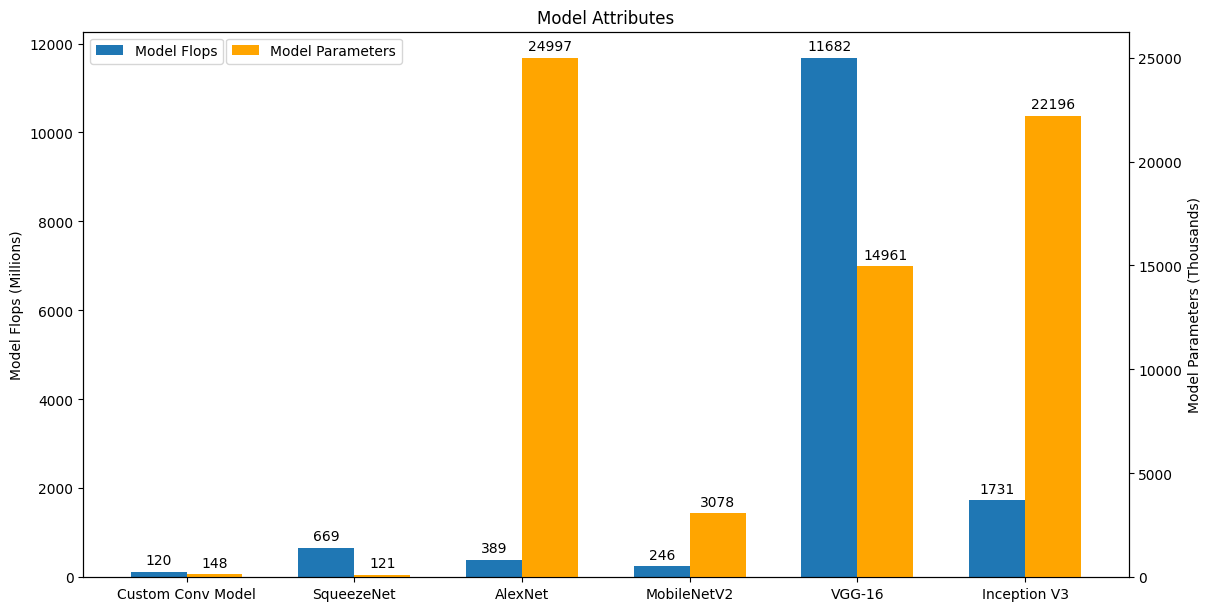

In [ ]:
model_names = ("Custom Conv Model", "SqueezeNet", "AlexNet", "MobileNetV2", "VGG-16", "Inception V3")
model_attributes = {
    'Model Flops': [round(x/1000000) for x in flop_list],
}

model_attributes2 = {
    'Model Parameters': [round(x/1000) for x in parameters_list],
}

x = np.arange(len(model_names))  # the label locations
width = 1/3  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(12,6)
ax2 = ax.twinx()

for attribute, measurement in model_attributes.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

for attribute, measurement in model_attributes2.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, color="orange")
    ax2.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Flops (Millions)')
ax2.set_ylabel('Model Parameters (Thousands)')
ax.set_title('Model Attributes')
ax.set_xticks(x + 1/6, model_names)
ax.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0.13, 1))
#ax.set_ylim(0, 8000)
#ax2.set_ylim(0, 15000)

plt.show()

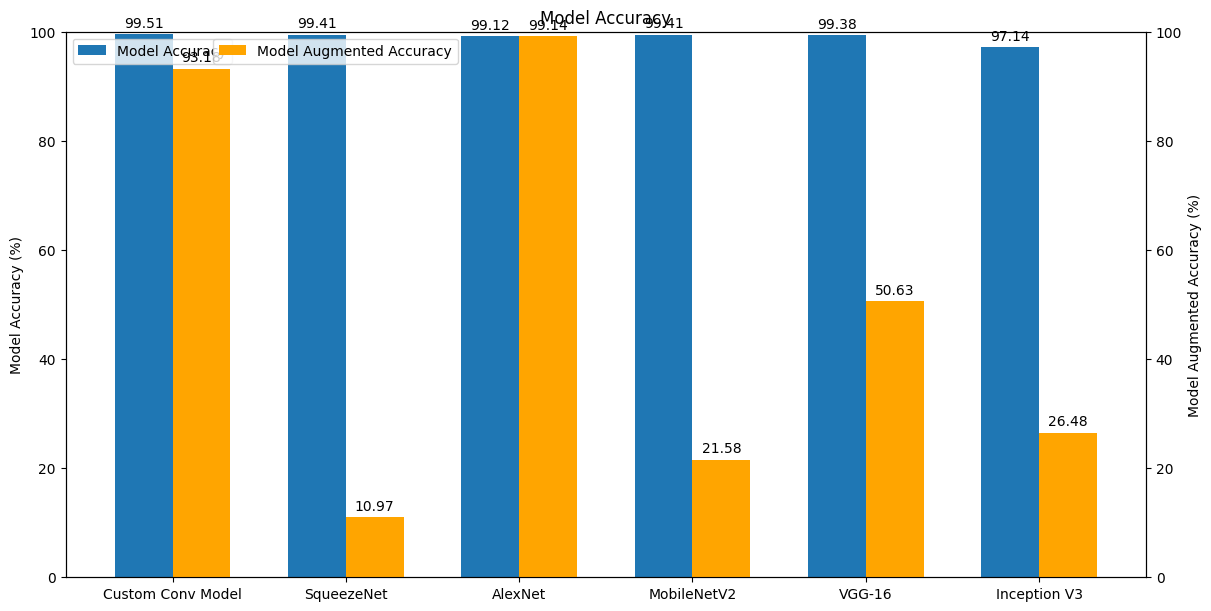

In [ ]:
model_attributes = {
    'Model Accuracy': [round(x, 2) for x in accuracies],
}

model_attributes2 = {
    'Model Augmented Accuracy': [round(x, 2) for x in aug_accuracies],
}

x = np.arange(len(model_names))  # the label locations
width = 1/3  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(12,6)
ax2 = ax.twinx()

for attribute, measurement in model_attributes.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

for attribute, measurement in model_attributes2.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, color="orange")
    ax2.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Accuracy (%)')
ax2.set_ylabel('Model Augmented Accuracy (%)')
ax.set_title('Model Accuracy')
ax.set_xticks(x + 1/6, model_names)
ax.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0.13, 1))
ax.set_ylim(0, 100)
ax2.set_ylim(0, 100)

plt.show()